In [1]:
import pandas as pd
from typing import List, Tuple
import numpy as np

from preprocess import create_min_max_df, scale_data, downsample_timeseries_data, slice_timeseries_data, masked_expand
from postprocess import generate_predictions

import importlib
import time

modules = ['cerberus_builder', 
           'cerberus_builder_attention',
           'cerberus_builder_attention_noneck',
           'cerberus_builder_noneck',
           'cerberus_builder_attention_hybrid']

# Setup
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'], 
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
df = df.iloc[:5000,:]
context_windows = ['1H', '2H', '6H']
context_sizes = [24, 12, 6]
call_window = '10T'
call_size = 24
response_window = '10T'
response_size = 8
call_feature_index = range(0,14)
context_feature_index = [range(0,14),
                        range(0,14),
                        range(0,14)]
response_feature_index = [0, 1, 4]
thresholds = {
    'call': 0.7,
    'response': 0.7,
    'context_0': 0.7,
    'context_1': 0.7,
    'context_2': 0.7
}
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

#Scale Data
min_max_df = create_min_max_df(df)

scaled_df = scale_data(df, min_max_df, feature_range=(0, 1))

downsampled_data = downsample_timeseries_data(scaled_df, 
                                        context_windows, 
                                        call_window, 
                                        response_window,
                                        call_feature_index,
                                        context_feature_index,
                                        response_feature_index)

sliced_data, selected_timestamps = slice_timeseries_data(downsampled_data,
                                    sizes,
                                    thresholds)

expanded_dict, response_data = masked_expand(sliced_data, sizes)

# Placeholder for results
results = []
models = []


In [2]:
# Loop through each module and perform tests
for module_name in modules:
    print(module_name)
    # Dynamically import the required functions
    module = importlib.import_module(module_name)
    build_cerberus = getattr(module, 'build_cerberus')
    train_cerberus = getattr(module, 'train_cerberus')
    
    tic = time.time()
    # Test cerberus
    model = build_cerberus(expanded_dict, response_data, 64)
    model = train_cerberus(model,expanded_dict, response_data, 1)
    
    train_call = expanded_dict['call']
    train_contexts = [expanded_dict[key] for key in expanded_dict if 'context' in key]
    train_response = expanded_dict['response']
    
    predicted = model.predict([train_call] + train_contexts + [train_response])

    training_rmse = np.sqrt(np.mean((predicted - response_data) ** 2))
    
    # Check individual generation
    selected_data = {key: value[400:401,:] for key, value in sliced_data.items()}
    responses_generated = generate_predictions(model,selected_data)
    observed = selected_data['response'][0,:,:]
    
    generated_rmse = np.sqrt(np.mean((responses_generated - observed) ** 2))
    
    toc = time.time()
     
    total_time = toc-tic
    
    # Record results
    results.append({
        'module': module_name,
        'train_time': total_time,
        'training_rmse': training_rmse,
        'generated_rmse':  generated_rmse
    })
    models.append(model)


cerberus_builder
1/1 [==============================] - 0s 27ms/step
cerberus_builder_attention
1/1 [==============================] - 0s 24ms/step
cerberus_builder_attention_noneck
1/1 [==============================] - 0s 63ms/step
cerberus_builder_noneck
1/1 [==============================] - 0s 26ms/step
cerberus_builder_attention_hybrid
1/1 [==============================] - 0s 25ms/step


In [3]:
results_df = pd.DataFrame(results)
results_df

,module,train_time,training_rmse,generated_rmse
0,cerberus_builder,83.980420,0.032580,0.017696
1,cerberus_builder_attention,79.905376,0.034509,0.015925
2,cerberus_builder_attention_noneck,49.837969,0.023950,0.016137
3,cerberus_builder_noneck,66.652943,0.026261,0.026664
4,cerberus_builder_attention_hybrid,60.709953,0.028024,0.013108


In [13]:
# Load in the best model
min_index = results_df['training_rmse'].idxmin()
model = models[min_index]

In [17]:
selected_data = {key: value[400:401,:] for key, value in sliced_data.items()}
responses_generated = generate_predictions(model,selected_data)
print(selected_data['response'])
print(responses_generated)

1/1 [==============================] - 0s 38ms/step
[[[0.66023229 0.69983687 0.88198542]
  [0.65843285 0.6995106  0.8785144 ]
  [0.65696058 0.6995106  0.87504339]
  [0.6554883  0.6995106  0.87157237]
  [0.65467037 0.69918434 0.86810135]
  [0.65483396 0.6995106  0.86636585]
  [0.6554883  0.69853181 0.86463034]
  [0.65696058 0.69755302 0.86636585]]]
[[0.6740363  0.70209235 0.85727257]
 [0.67530614 0.7044191  0.8708657 ]
 [0.6762416  0.7039959  0.8749811 ]
 [0.6779549  0.70483696 0.86840904]
 [0.6774955  0.70416117 0.8695554 ]
 [0.6770005  0.70357406 0.87108874]
 [0.6763265  0.7031606  0.87282914]
 [0.67525655 0.70270747 0.87362856]]


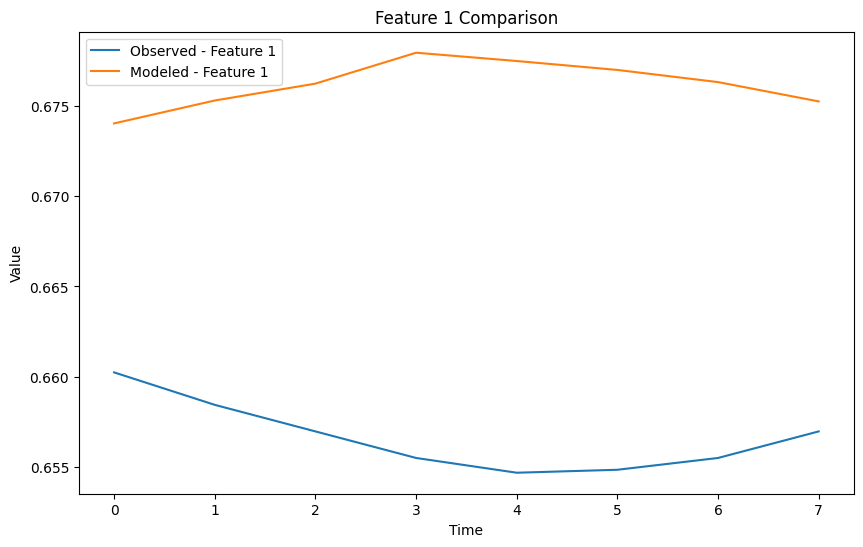

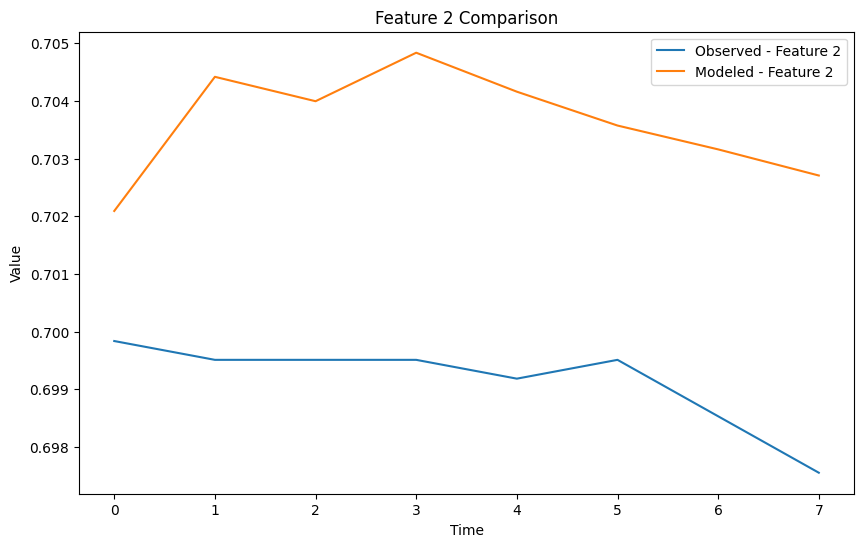

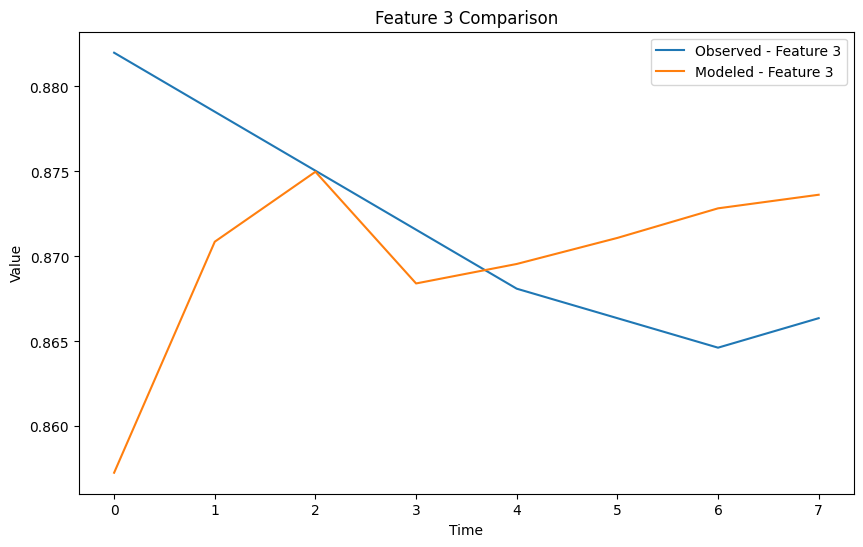

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Example matrices
observed = selected_data['response'][0,:,:]
modeled = responses_generated

# Number of rows and columns
num_rows, num_cols = observed.shape

# Create a plot for each feature (column)
for i in range(num_cols):
    plt.figure(figsize=(10, 6))
    plt.plot(observed[:, i], label='Observed - Feature {}'.format(i+1))
    plt.plot(modeled[:, i], label='Modeled - Feature {}'.format(i+1))
    plt.title(f'Feature {i+1} Comparison')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
